Copyright **`(c)`** 2024 Giovanni Squillero `<giovanni.squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free for personal or classroom use; see [`LICENSE.md`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  

# Set Cover problem

See: https://en.wikipedia.org/wiki/Set_cover_problem

In [1]:
from random import random, seed
from itertools import product, accumulate
import numpy as np
from icecream import ic
from tqdm.auto import tqdm
import math
import matplotlib.pyplot as plt

## Reproducible Initialization

If you want to get reproducible results, use `rng` (and restart the kernel); for non-reproducible ones, use `np.random`.

In [2]:
def generate_data(universe_size, num_sets, density):
    global UNIVERSE_SIZE, NUM_SETS, DENSITY, SETS, COSTS, rng
    UNIVERSE_SIZE = universe_size
    NUM_SETS = num_sets
    DENSITY = density
    
    rng = np.random.Generator(np.random.PCG64([UNIVERSE_SIZE, NUM_SETS, int(10_000 * DENSITY)]))
    
    SETS = np.random.random((NUM_SETS, UNIVERSE_SIZE)) < DENSITY
    for s in range(UNIVERSE_SIZE):
        if not np.any(SETS[:, s]):
            SETS[np.random.randint(NUM_SETS), s] = True
    COSTS = np.pow(SETS.sum(axis=1), 1.1)
    return SETS, COSTS

## Helper Functions

In [3]:
def valid(solution):
    """Checks wether solution is valid (ie. covers all universe)"""
    return np.all(np.logical_or.reduce(SETS[solution]))


def cost(solution):
    """Returns the cost of a solution (to be minimized)"""
    return COSTS[solution].sum()

def fitness(solution):
    return (valid(solution), -cost(solution))
    

## Simple greedy approach 

While Universe is not covered:
- Select the set that has the minimum cost
- Add the set to the solution
- Repeat until the Universe is covered

This solution will be used as starting point for RMHC.

In [4]:
def greedy_approach():
    solution = np.full(NUM_SETS, False)
    past_indexes = set()
    steps = 0
    while not valid(solution):
        steps += 1
        # Finding the set with minimum cost
        index = None
        smaller_cost = COSTS[0]
        for i in range(NUM_SETS):
            if COSTS[i] < smaller_cost and (i not in past_indexes):
                smaller_cost = COSTS[i]
                past_indexes.add(i)
                index = i

        # Add set to the solution
        solution[index] = True

    return solution, cost(solution), steps

## Random Mutation Hill Climber
Starting from the greedy solution, RMHC tries to optimize the solution.
The algorithm tweaks the solution and eventually accepts it if it is better than the current one.
Various tweaks are possible, including:
- Flipping a random bit
- Activate or deactivate a random set with a certain probability


In [5]:
def single_tweak(solution):
    new_solution = solution.copy()
    index = np.random.randint(0, NUM_SETS)
    new_solution[index] = not new_solution[index]

    return new_solution

In [6]:
# Not used
def multiple_tweak(solution, strenght):
    mask = rng.random(NUM_SETS) < strenght
    new_solution = np.logical_xor(solution, mask)
    return new_solution

In [7]:
def activate_tweak(solution):
    new_solution = solution.copy()
    activate_set = rng.random() < 0.5
    
    if activate_set:
        candidates = np.where(new_solution == False)[0]
        if len(candidates) > 0:
            index = rng.choice(candidates)
            new_solution[index] = True
    else:
        candidates = np.where(new_solution == True)[0]
        if len(candidates) > 0:
            index = rng.choice(candidates)
            new_solution[index] = False
    
    while np.random.random() < 0.5:
        index = rng.integers(NUM_SETS)
        new_solution[index] = ~new_solution[index]
    
    return new_solution

In [8]:
def rmhc(initial_solution, max_iter, tweak_function):
    tweak = tweak_function
    history = []
    solution = initial_solution.copy()
    history.append(fitness(solution)[1])
    steps = 0
    final_steps = None

    
    for i in tqdm(range(max_iter)):
        steps += 1
        new_solution = tweak(solution)
        new_fitness = fitness(new_solution)
        history.append(new_fitness[1])
        if  new_fitness > fitness(solution):
            solution = new_solution
            final_steps = steps
        

    plt.figure(figsize=(14, 8))
    if tweak_function == single_tweak:
        plt.title("RMHC with single mutation")
    else:
        plt.title("RMHC with activate/deactivate tweak")
    plt.xlabel("Iteration")
    plt.ylabel("Fitness")
    plt.plot(
    range(len(history)),
    list(accumulate(history, max)),
    color="red",
)
    _ = plt.scatter(range(len(history)), history, marker=".")
    plt.show()
    return solution, cost(solution), final_steps


## Solution

  0%|          | 0/10000 [00:00<?, ?it/s]

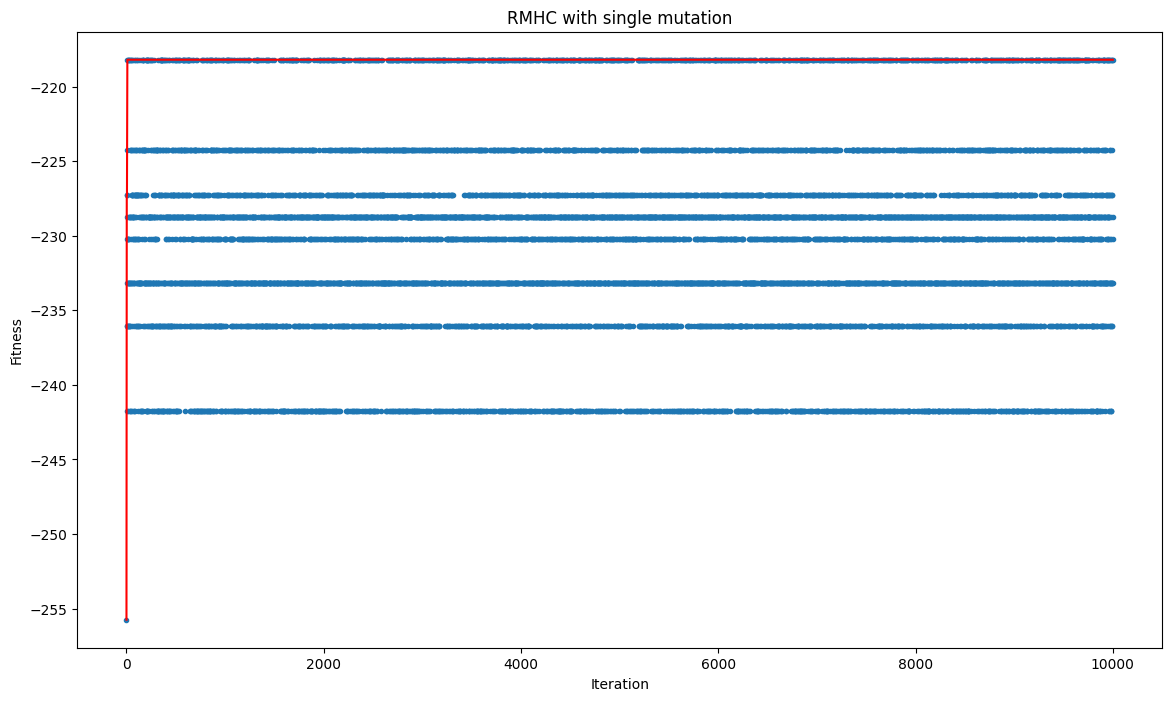

ic| config: (100, 10, 0.2)
    GREEDY_COST: np.float64(255.74300608994187)
    GREEDY_STEPS: 2
    RMHC_SINGLE_COST: np.float64(255.74300608994187)
    RMHC_SINGLE_STEPS: None


  0%|          | 0/10000 [00:00<?, ?it/s]

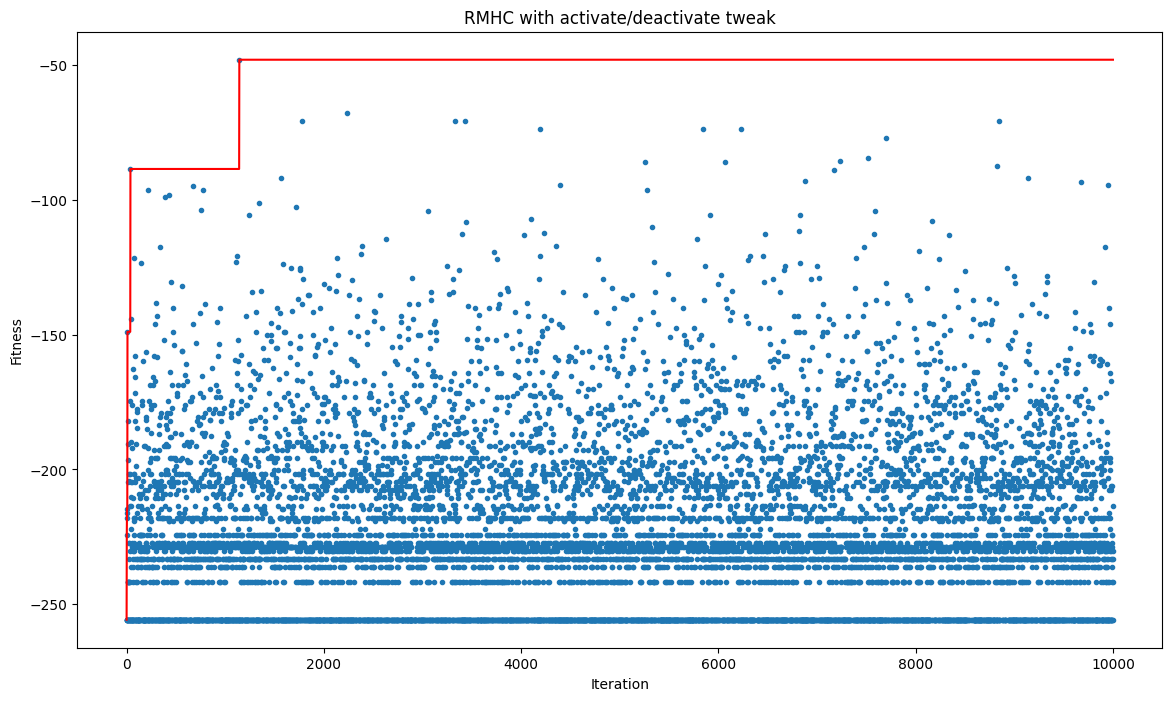

ic| config: (100, 10, 0.2)
    GREEDY_COST: np.float64(255.74300608994187)
    GREEDY_STEPS: 2
    RMHC_ACTIV_COST: np.float64(255.74300608994187)
    RMHC_ACTIV_STEPS: None


  0%|          | 0/10000 [00:00<?, ?it/s]

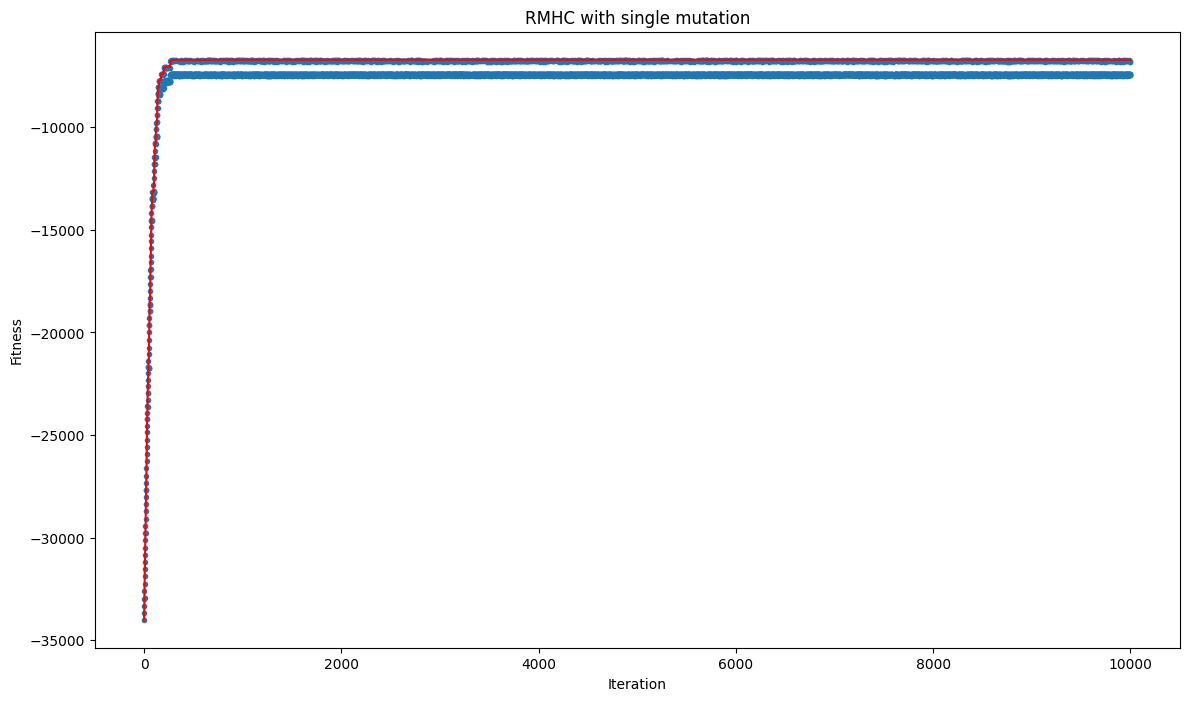

ic| config: (1000, 100, 0.2)
    GREEDY_COST: np.float64(33994.66801295645)
    GREEDY_STEPS: 21
    RMHC_SINGLE_COST: np.float64(7102.037760439383)
    RMHC_SINGLE_STEPS: 263


  0%|          | 0/10000 [00:00<?, ?it/s]

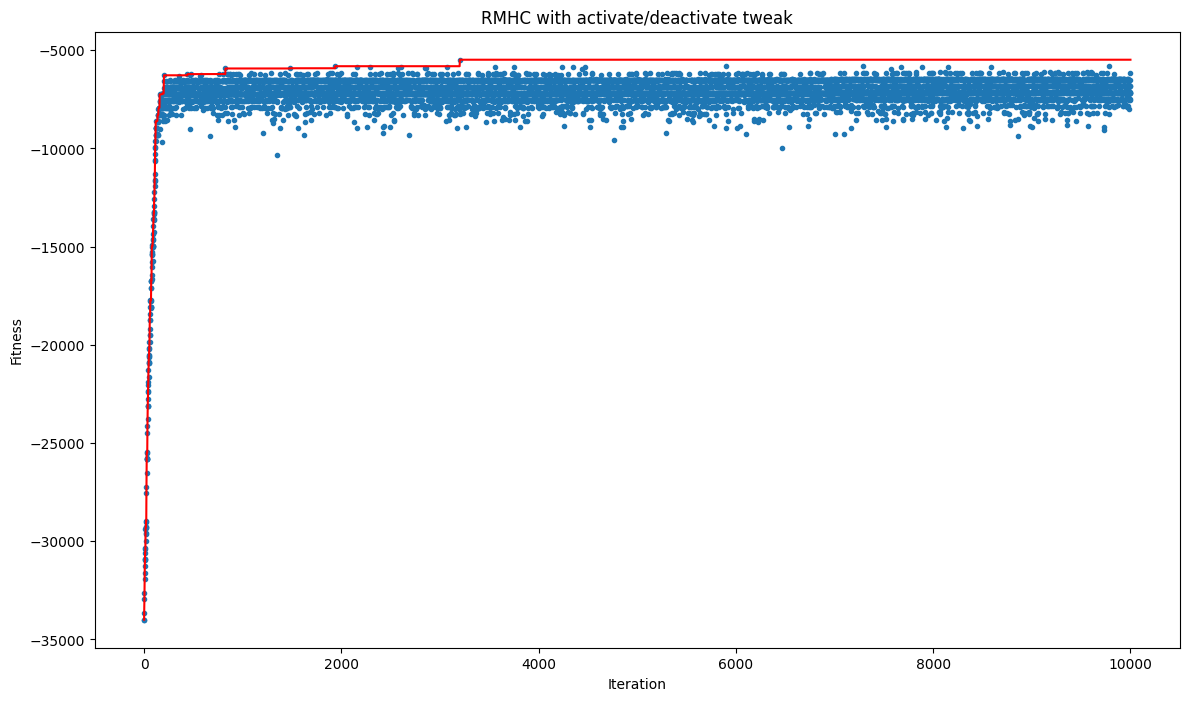

ic| config: (1000, 100, 0.2)
    GREEDY_COST: np.float64(33994.66801295645)
    GREEDY_STEPS: 21
    RMHC_ACTIV_COST: np.float64(6812.5949383042225)
    RMHC_ACTIV_STEPS: 8521


  0%|          | 0/10000 [00:00<?, ?it/s]

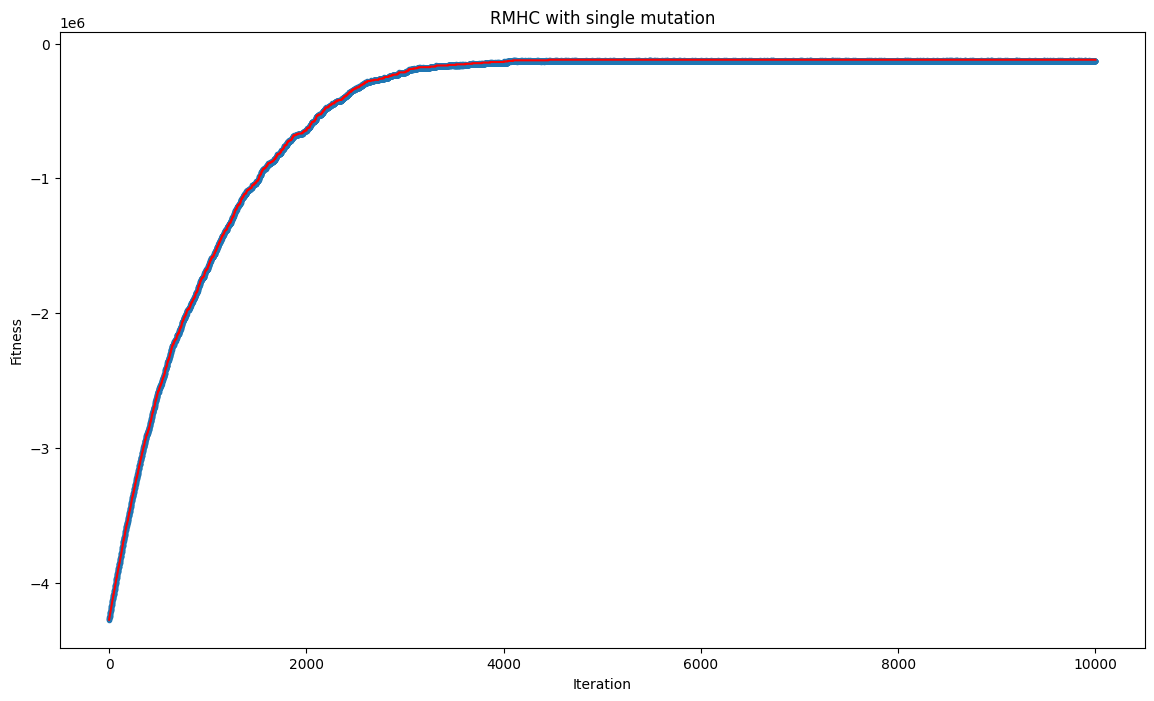

ic| config: (10000, 1000, 0.2)
    GREEDY_COST: np.float64(4276165.6864888)
    GREEDY_STEPS: 44
    RMHC_SINGLE_COST: np.float64(124235.44047840728)
    RMHC_SINGLE_STEPS: 4429


  0%|          | 0/10000 [00:00<?, ?it/s]

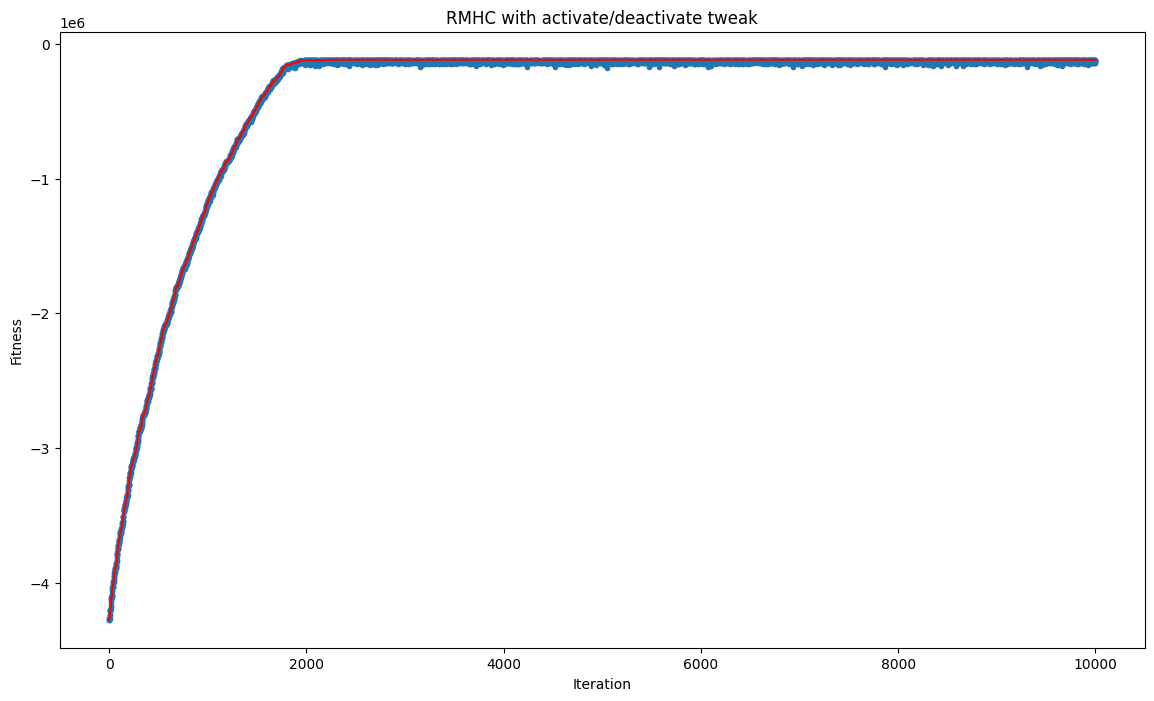

ic| config: (10000, 1000, 0.2)
    GREEDY_COST: np.float64(4276165.6864888)
    GREEDY_STEPS: 44
    RMHC_ACTIV_COST: np.float64(126062.82513108851)
    RMHC_ACTIV_STEPS: 9696


  0%|          | 0/10000 [00:00<?, ?it/s]

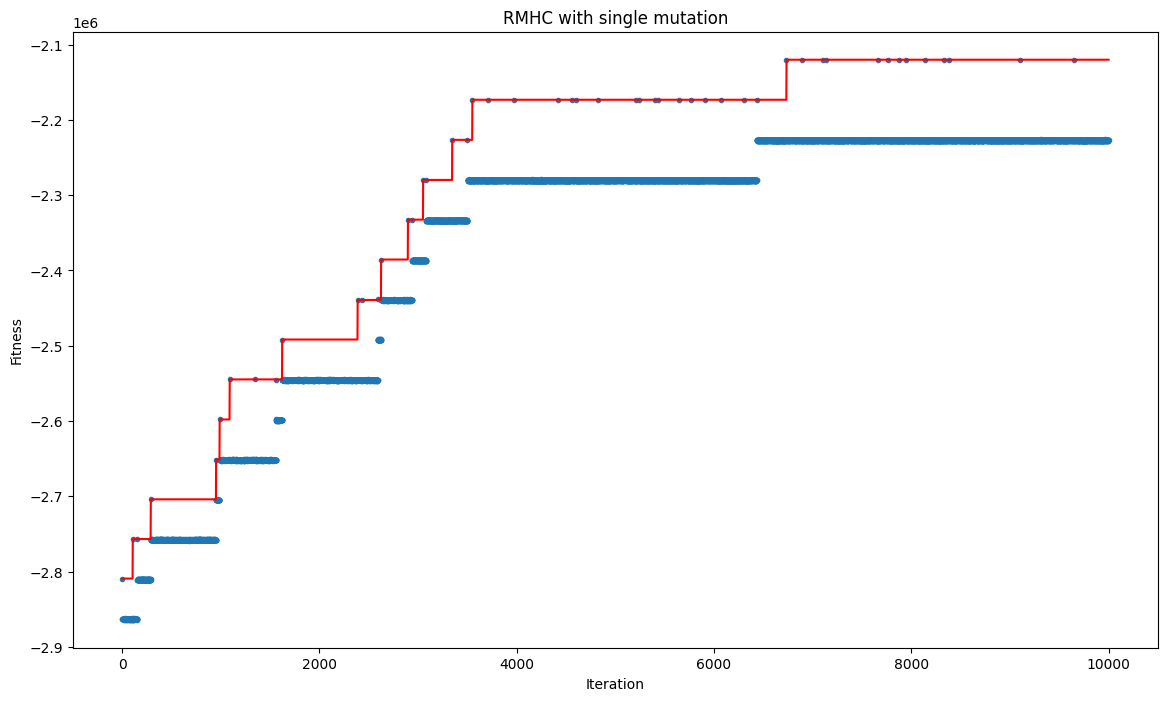

ic| config: (100000, 10000, 0.2)
    GREEDY_COST: np.float64(2809334.3956289864)
    GREEDY_STEPS: 53
    RMHC_SINGLE_COST: np.float64(2173244.1639334187)
    RMHC_SINGLE_STEPS: 6433


  0%|          | 0/10000 [00:00<?, ?it/s]

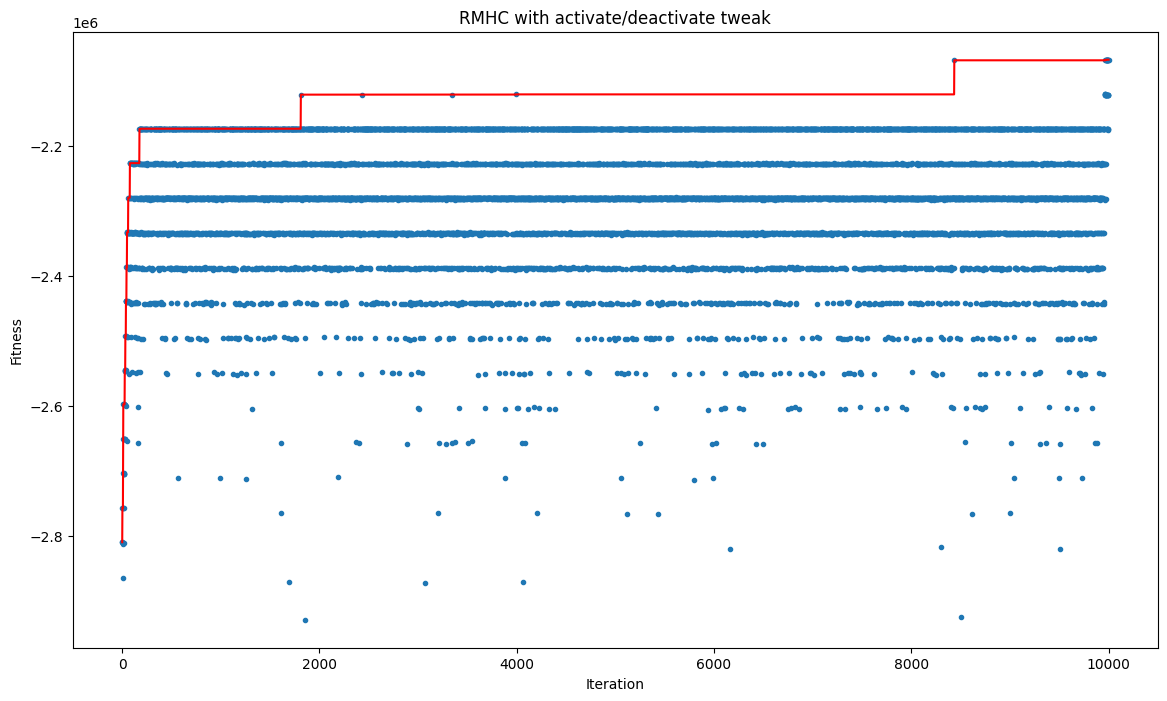

ic| config: (100000, 10000, 0.2)
    GREEDY_COST: np.float64(2809334.3956289864)
    GREEDY_STEPS: 53
    RMHC_ACTIV_COST: np.float64(2120137.7234854694)
    RMHC_ACTIV_STEPS: 9963


  0%|          | 0/10000 [00:00<?, ?it/s]

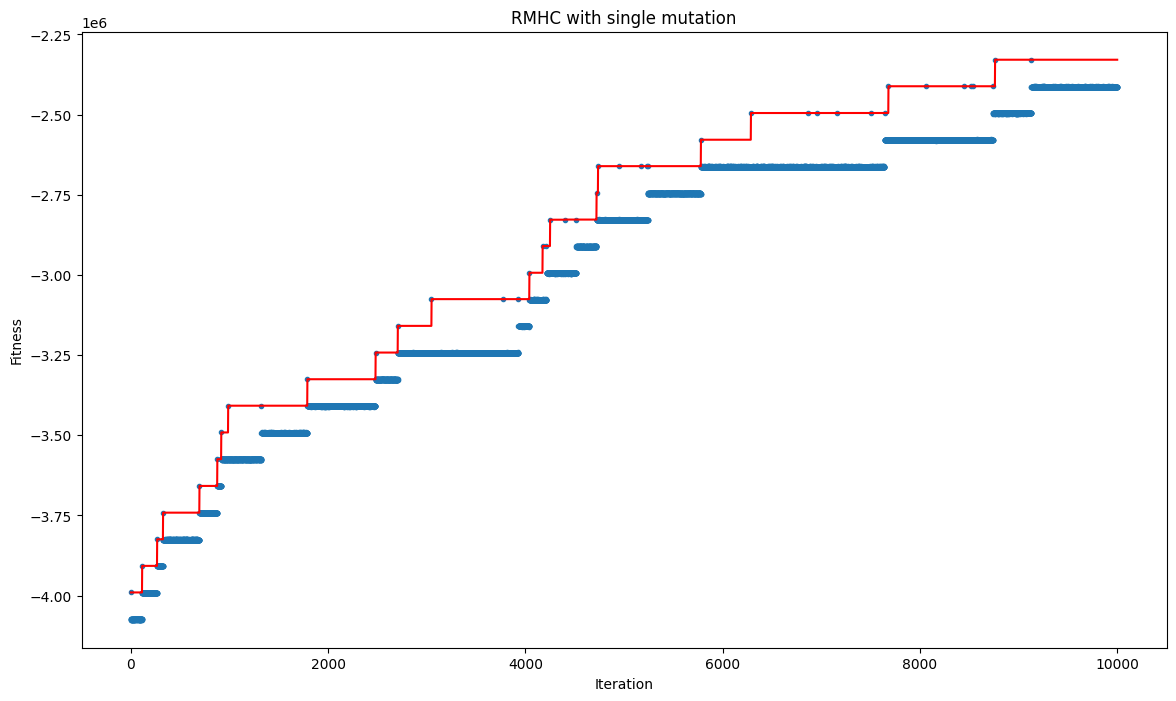

ic| config: (100000, 10000, 0.3)
    GREEDY_COST: np.float64(3990011.620786216)
    GREEDY_STEPS: 48
    RMHC_SINGLE_COST: np.float64(2329157.2944820896)
    RMHC_SINGLE_STEPS: 9129


  0%|          | 0/10000 [00:00<?, ?it/s]

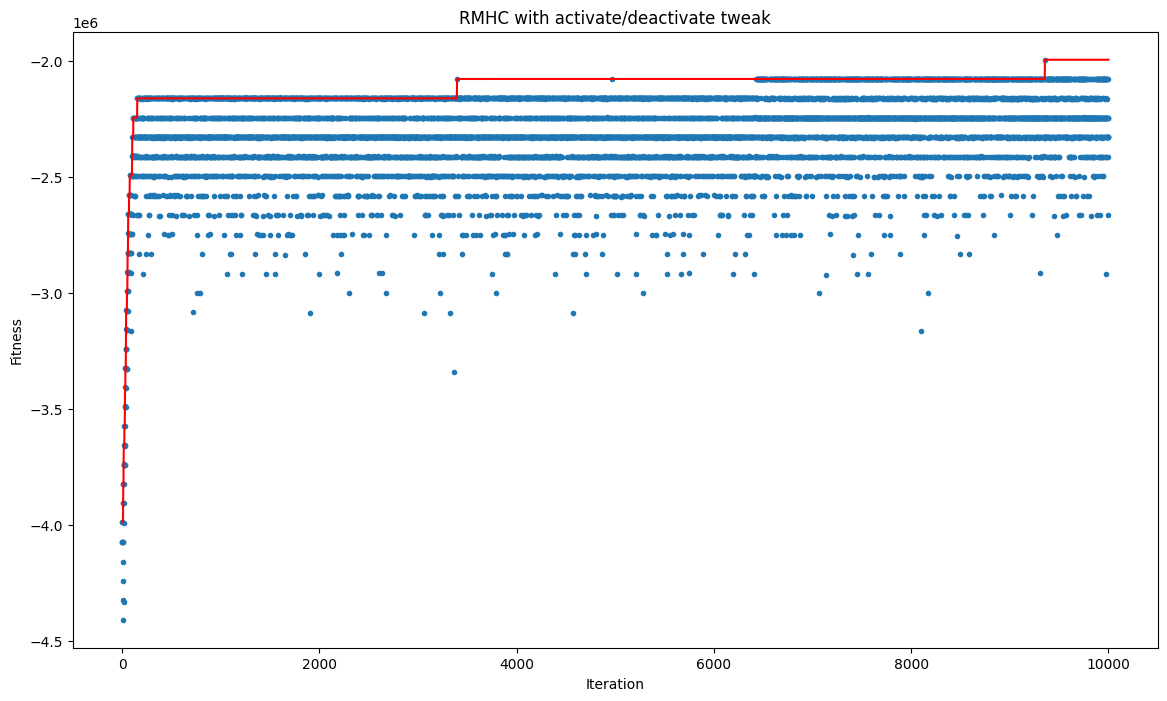

ic| config: (100000, 10000, 0.3)
    GREEDY_COST: np.float64(3990011.620786216)
    GREEDY_STEPS: 48
    RMHC_ACTIV_COST: np.float64(2162164.1778096417)
    RMHC_ACTIV_STEPS: 6428


  0%|          | 0/10000 [00:00<?, ?it/s]

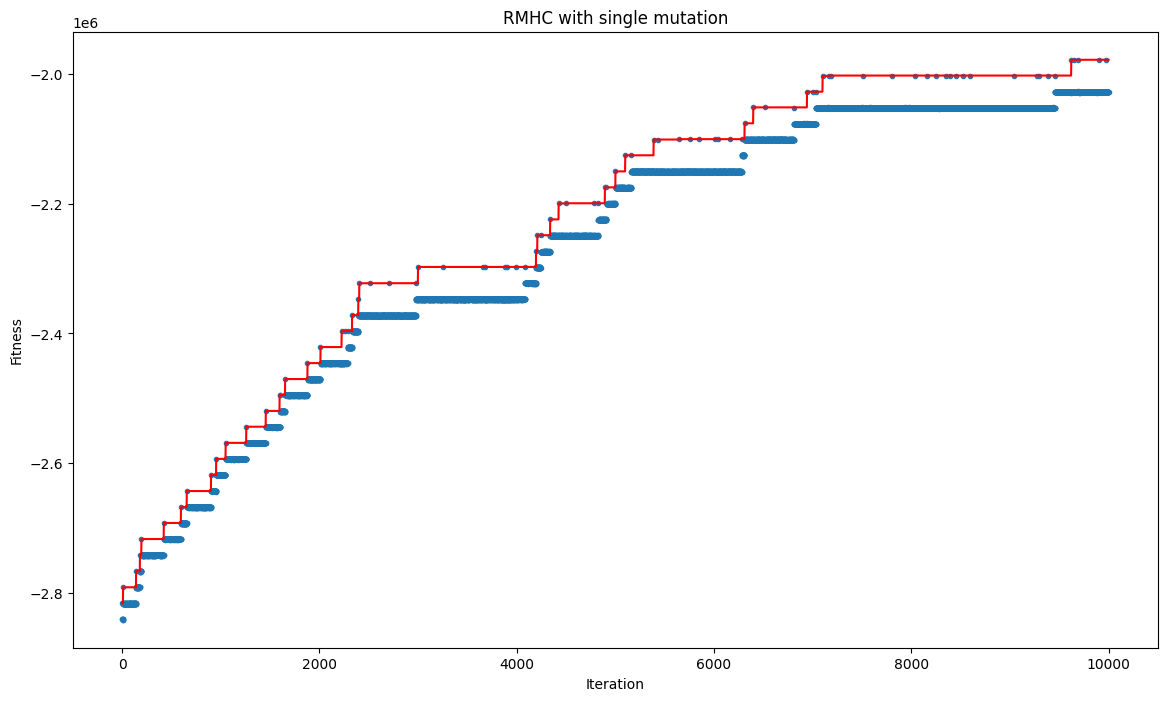

ic| config: (100000, 10000, 0.1)
    GREEDY_COST: np.float64(2816360.75653275)
    GREEDY_STEPS: 114
    RMHC_SINGLE_COST: np.float64(2002333.085447347)
    RMHC_SINGLE_STEPS: 9456


  0%|          | 0/10000 [00:00<?, ?it/s]

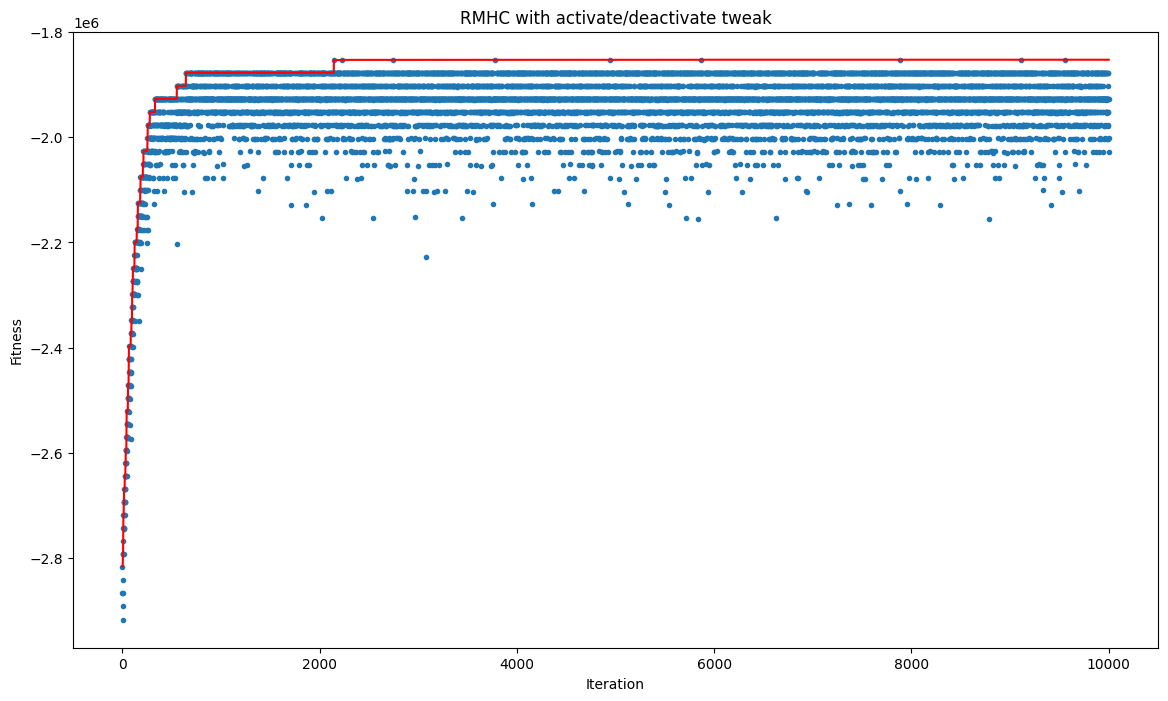

ic| config: (100000, 10000, 0.1)
    GREEDY_COST: np.float64(2816360.75653275)
    GREEDY_STEPS: 114
    RMHC_ACTIV_COST: np.float64(1901967.0878716998)
    RMHC_ACTIV_STEPS: 643


In [9]:
for config in [(100,10,0.2), (1000,100,0.2), (10000,1000,0.2), (100000,10000,0.2), (100000,10000,0.3), (100000,10000,0.1)]:
    
    SETS, COSTS = generate_data(config[0], config[1], config[2])
    
    GREEDY_SOLUTION, GREEDY_COST, GREEDY_STEPS = greedy_approach()
    
    RMHC_SINGLE_SOLUTION, RMHC_SINGLE_COST, RMHC_SINGLE_STEPS = rmhc(GREEDY_SOLUTION, 10000, single_tweak)
    ic(config, GREEDY_COST, GREEDY_STEPS, RMHC_SINGLE_COST, RMHC_SINGLE_STEPS)
    
    RMHC_ACTIV_SOLUTION, RMHC_ACTIV_COST, RMHC_ACTIV_STEPS = rmhc(GREEDY_SOLUTION, 10000, activate_tweak)
    ic(config, GREEDY_COST, GREEDY_STEPS, RMHC_ACTIV_COST, RMHC_ACTIV_STEPS)
    

Each IC output refers to the plot **above** it

# Results

This table summarizes the results obtained with the different algorithms and parameters.
The greedy costs are the starting point for the RMHC.
The 'Number of evaluations' is the number of evaluations needed to reach the final solution (remaining evaluations are not counted).

| Algorithm | Universe size | Number of sets | Density | Final cost | Number of evaluations|
|-----------|---------------|----------------|---------|------------|----------------------|
| Greedy    | 100           | 10            | 0.2    |    255        |       2               |
|           | 1000          | 100           | 0.2     |   33994         |        21              |
|           | 10000        | 1000           | 0.2     |  4276165          |       44              |
|           | 100000           | 10000            | 0.2     |  2809394          |   53                  |
|           | 100000         | 10000         | 0.1     |    2816360        |         114             |
|           | 100000         | 10000         | 0.3     |    3990011        |            48          |
| RMHC (single mutation)      | 100           | 10            | 0.2     |    255        |          Same as greedy            |
|           | 1000          | 100           | 0.2     |    7102        |          263            |
|           | 10000        | 1000           | 0.2     |   124235         |         4429             |
|           | 100000           | 10000            | 0.2     |    2173244        |         6433             |
|           | 100000         | 10000         | 0.1     |   2002333         |    9456                  |
|           | 100000         | 10000         | 0.3     |   2329157         |           9129           |
| RMHC (activate/deactivate) | 100           | 10            | 0.2     |      255      | Same as greedy                     |
|           | 1000          | 100           | 0.2     |  6812          |        8521              |
|           | 10000        | 1000           | 0.2     |  126062          |         9696             |
|           | 100000           | 10000            | 0.2     |   2120137         |      9963                |
|           | 100000         | 10000         | 0.1     |  1901967          |      643                |
|           | 100000         | 10000         | 0.3     |   2162164         |     6428                 |

